# Dataset Balance Analysis

This notebook analyses the class distributions in `dataset_SVM.parquet` and `dataset_DTW.parquet` to determine whether the datasets are balanced.

> **Note:** Both datasets store rows as sliding windows of TD9 features. For the **SVM** dataset the natural unit of counting is the *window*. For the **DTW** dataset the natural unit is the *repetition* (a group of windows sharing the same `user` + `sample_id`), so all DTW counts below are computed by counting unique repetitions.

**Metrics computed:**
- Absolute and relative class frequencies
- Imbalance Ratio (IR) — ratio of the largest class to the smallest
- Per-user class distributions
- Visual comparison between the two dataset variants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams.update({"figure.dpi": 120, "axes.titlesize": 13, "axes.labelsize": 11})

## 1 — Load datasets

In [2]:
DATA_DIR = "../preprocessed_output"

df_svm = pd.read_parquet(f"{DATA_DIR}/dataset_SVM.parquet")
df_dtw = pd.read_parquet(f"{DATA_DIR}/dataset_DTW.parquet")

# For DTW, collapse windows into repetitions (one row per user+sample_id)
dtw_reps = df_dtw.groupby(["user", "sample_id"]).first()[["label"]].reset_index()

print(f"SVM dataset : {df_svm.shape[0]:,} windows × {df_svm.shape[1]} cols")
print(f"DTW dataset : {df_dtw.shape[0]:,} windows → {len(dtw_reps):,} unique repetitions")
print(f"Labels (SVM): {sorted(df_svm['label'].unique())}")
print(f"Labels (DTW): {sorted(dtw_reps['label'].unique())}")

SVM dataset : 1,015,161 windows × 76 cols
DTW dataset : 922,416 windows → 41,105 unique repetitions
Labels (SVM): ['fist', 'noGesture', 'open', 'pinch', 'waveIn', 'waveOut']
Labels (DTW): ['fist', 'noGesture', 'open', 'pinch', 'waveIn', 'waveOut']


## 2 — Overall class distribution

In [3]:
def class_distribution_table(df, name, unit="samples"):
    """Return a summary DataFrame with count, percentage, and ratio to majority."""
    counts = df["label"].value_counts().sort_index()
    total  = counts.sum()
    majority = counts.max()
    summary = pd.DataFrame({
        "count":      counts,
        "pct (%)":    (counts / total * 100).round(2),
        "ratio_to_majority": (counts / majority).round(4),
    })
    summary.index.name = "label"
    ir = majority / counts.min()
    print(f"\n{'='*50}")
    print(f"  {name} — Class Distribution")
    print(f"{'='*50}")
    print(f"  Total {unit} : {total:,}")
    print(f"  Majority class: {counts.idxmax()} ({majority:,})")
    print(f"  Minority class: {counts.idxmin()} ({counts.min():,})")
    print(f"  Imbalance Ratio (IR = max/min): {ir:.4f}")
    print(f"  Ideal balanced pct per class  : {100/len(counts):.2f}%")
    print()
    display(summary)
    return summary, ir

svm_summary, svm_ir = class_distribution_table(df_svm, "SVM", unit="windows")
dtw_summary, dtw_ir = class_distribution_table(dtw_reps, "DTW", unit="repetitions")


  SVM — Class Distribution
  Total windows : 1,015,161
  Majority class: waveOut (178,647)
  Minority class: open (154,370)
  Imbalance Ratio (IR = max/min): 1.1573
  Ideal balanced pct per class  : 16.67%



,count,pct (%),ratio_to_majority
label,,,
fist,165283,16.28,0.9252
noGesture,175950,17.33,0.9849
open,154370,15.21,0.8641
pinch,171537,16.90,0.9602
waveIn,169374,16.68,0.9481
waveOut,178647,17.60,1.0000



  DTW — Class Distribution
  Total repetitions : 41,105
  Majority class: noGesture (7,650)
  Minority class: fist (5,241)
  Imbalance Ratio (IR = max/min): 1.4596
  Ideal balanced pct per class  : 16.67%



,count,pct (%),ratio_to_majority
label,,,
fist,5241,12.75,0.6851
noGesture,7650,18.61,1.0000
open,7404,18.01,0.9678
pinch,7525,18.31,0.9837
waveIn,6505,15.83,0.8503
waveOut,6780,16.49,0.8863


## 3 — Bar-chart comparison

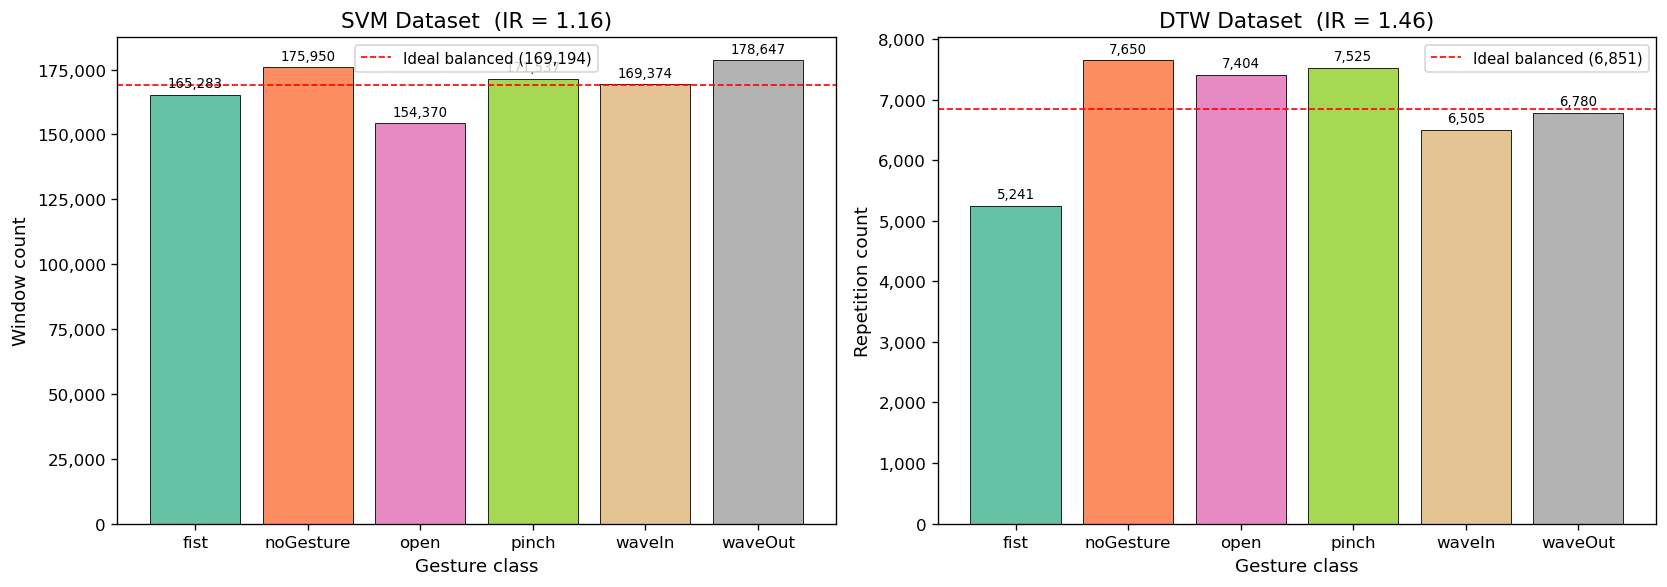

In [4]:
labels_order = sorted(df_svm["label"].unique())

# unit labels per dataset
units = {"SVM": "Window count", "DTW": "Repetition count"}
# data sources: raw df for SVM, collapsed repetitions for DTW
sources = {"SVM": df_svm, "DTW": dtw_reps}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

for ax, (name, ir) in zip(axes, [("SVM", svm_ir), ("DTW", dtw_ir)]):
    df_plot = sources[name]
    counts = df_plot["label"].value_counts().reindex(labels_order)
    colours = plt.cm.Set2(np.linspace(0, 1, len(labels_order)))
    bars = ax.bar(labels_order, counts, color=colours, edgecolor="black", linewidth=0.5)

    # balanced reference line
    balanced = counts.sum() / len(labels_order)
    ax.axhline(balanced, ls="--", color="red", linewidth=1, label=f"Ideal balanced ({balanced:,.0f})")

    # annotate bars
    for bar, val in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + counts.max() * 0.01,
                f"{val:,}", ha="center", va="bottom", fontsize=8)

    ax.set_title(f"{name} Dataset  (IR = {ir:.2f})")
    ax.set_ylabel(units[name])
    ax.set_xlabel("Gesture class")
    ax.legend(fontsize=9)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

## 4 — Percentage distribution (pie charts)

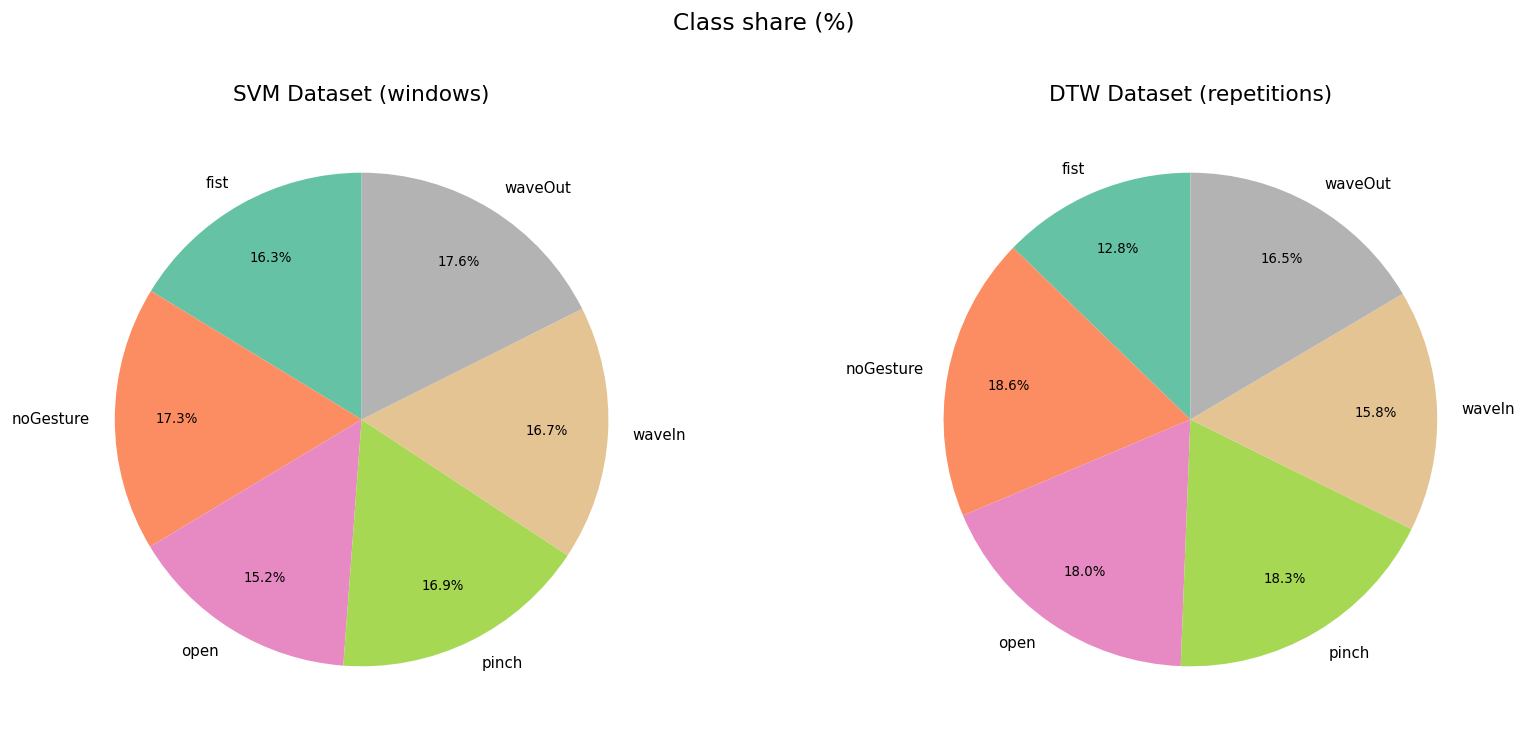

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (df_plot, name) in zip(axes, [(df_svm, "SVM"), (dtw_reps, "DTW")]):
    counts = df_plot["label"].value_counts().reindex(labels_order)
    colours = plt.cm.Set2(np.linspace(0, 1, len(labels_order)))
    wedges, texts, autotexts = ax.pie(
        counts, labels=labels_order, autopct="%1.1f%%",
        colors=colours, startangle=90, pctdistance=0.75,
        textprops={"fontsize": 9},
    )
    for t in autotexts:
        t.set_fontsize(8)
    unit = "windows" if name == "SVM" else "repetitions"
    ax.set_title(f"{name} Dataset ({unit})")

plt.suptitle("Class share (%)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5 — Per-user class balance

Compute the Imbalance Ratio (IR) for each user individually to check whether certain users are more imbalanced than others.
- **SVM**: counted per sliding window
- **DTW**: counted per repetition

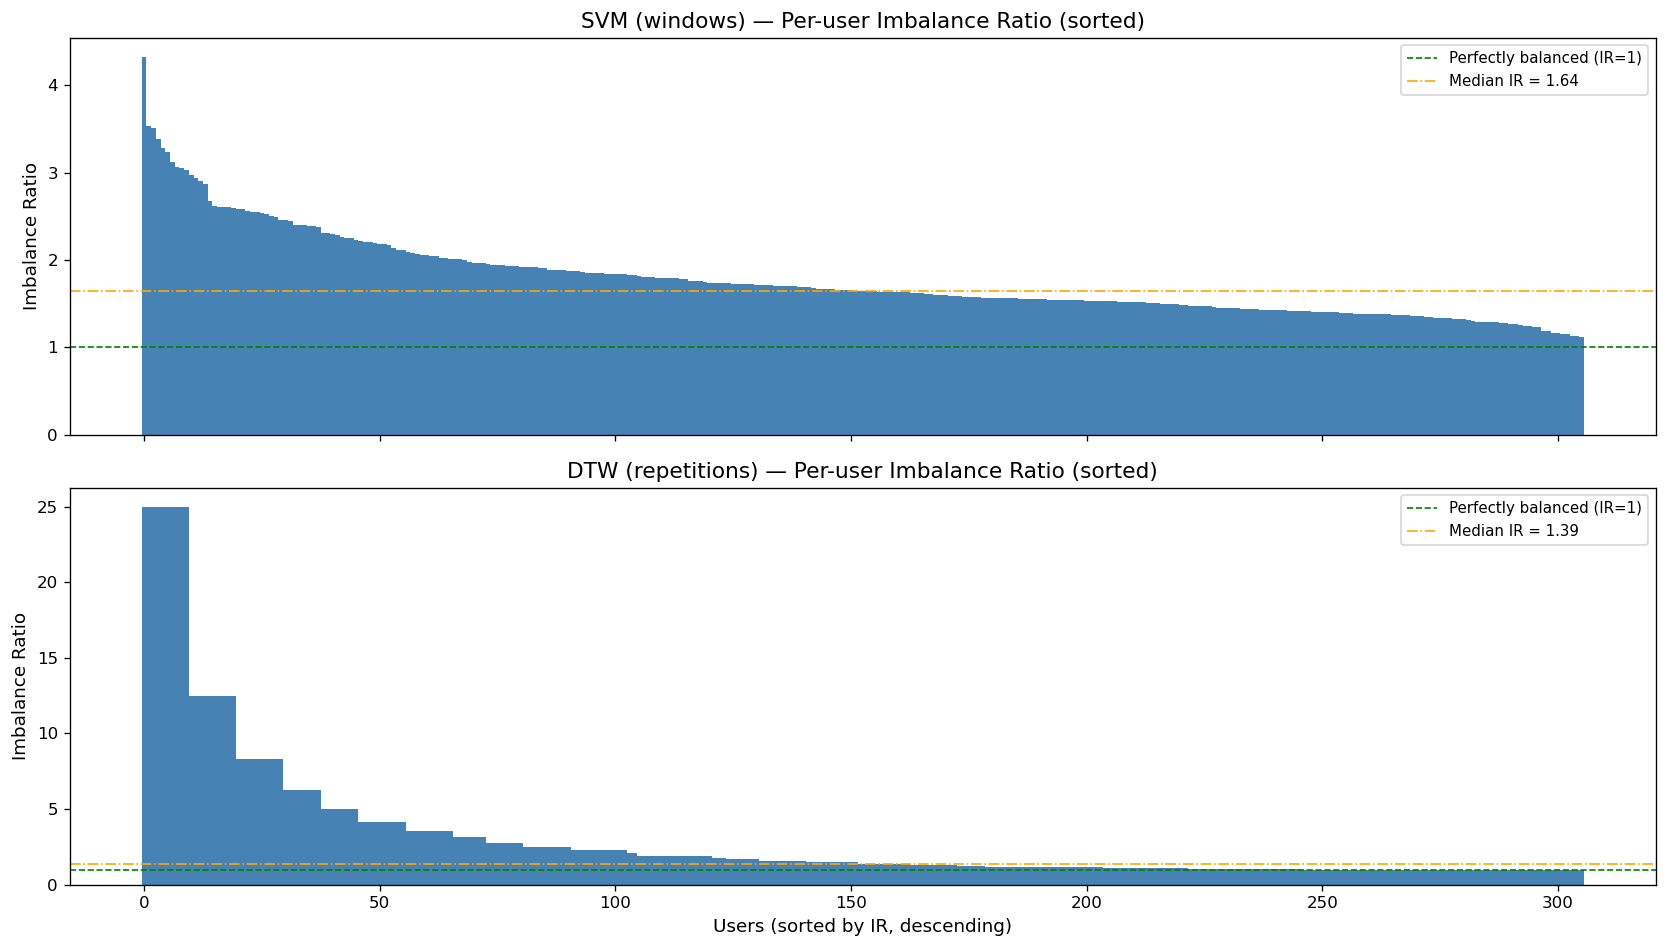

Per-user IR statistics:


,SVM (windows),DTW (repetitions)
count,306.0000,306.0000
mean,1.7786,3.1872
std,0.4759,4.7219
min,1.1135,1.0000
25%,1.4552,1.0417
50%,1.6432,1.3889
75%,1.9412,2.7778
max,4.3233,25.0000


In [6]:
def per_user_ir(df):
    """Return a Series of per-user imbalance ratios."""
    def _ir(g):
        counts = g.value_counts()
        return counts.max() / counts.min() if counts.min() > 0 else np.inf
    return df.groupby("user")["label"].apply(_ir).rename("IR")

ir_svm = per_user_ir(df_svm)       # counted per window
ir_dtw = per_user_ir(dtw_reps)     # counted per repetition

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for ax, (ir, name) in zip(axes, [(ir_svm, "SVM (windows)"), (ir_dtw, "DTW (repetitions)")]):
    ir_sorted = ir.sort_values(ascending=False)
    ax.bar(range(len(ir_sorted)), ir_sorted.values, width=1.0, color="steelblue", edgecolor="none")
    ax.axhline(1.0, ls="--", color="green", linewidth=1, label="Perfectly balanced (IR=1)")
    ax.axhline(ir.median(), ls="-.", color="orange", linewidth=1,
               label=f"Median IR = {ir.median():.2f}")
    ax.set_ylabel("Imbalance Ratio")
    ax.set_title(f"{name} — Per-user Imbalance Ratio (sorted)")
    ax.legend(fontsize=9)

axes[-1].set_xlabel("Users (sorted by IR, descending)")
plt.tight_layout()
plt.show()

print("Per-user IR statistics:")
ir_stats = pd.DataFrame({
    "SVM (windows)": ir_svm.describe(),
    "DTW (repetitions)": ir_dtw.describe(),
}).round(4)
display(ir_stats)

## 6 — Per-user class-count heatmap

Shows sample counts per user × class (windows for SVM, repetitions for DTW).

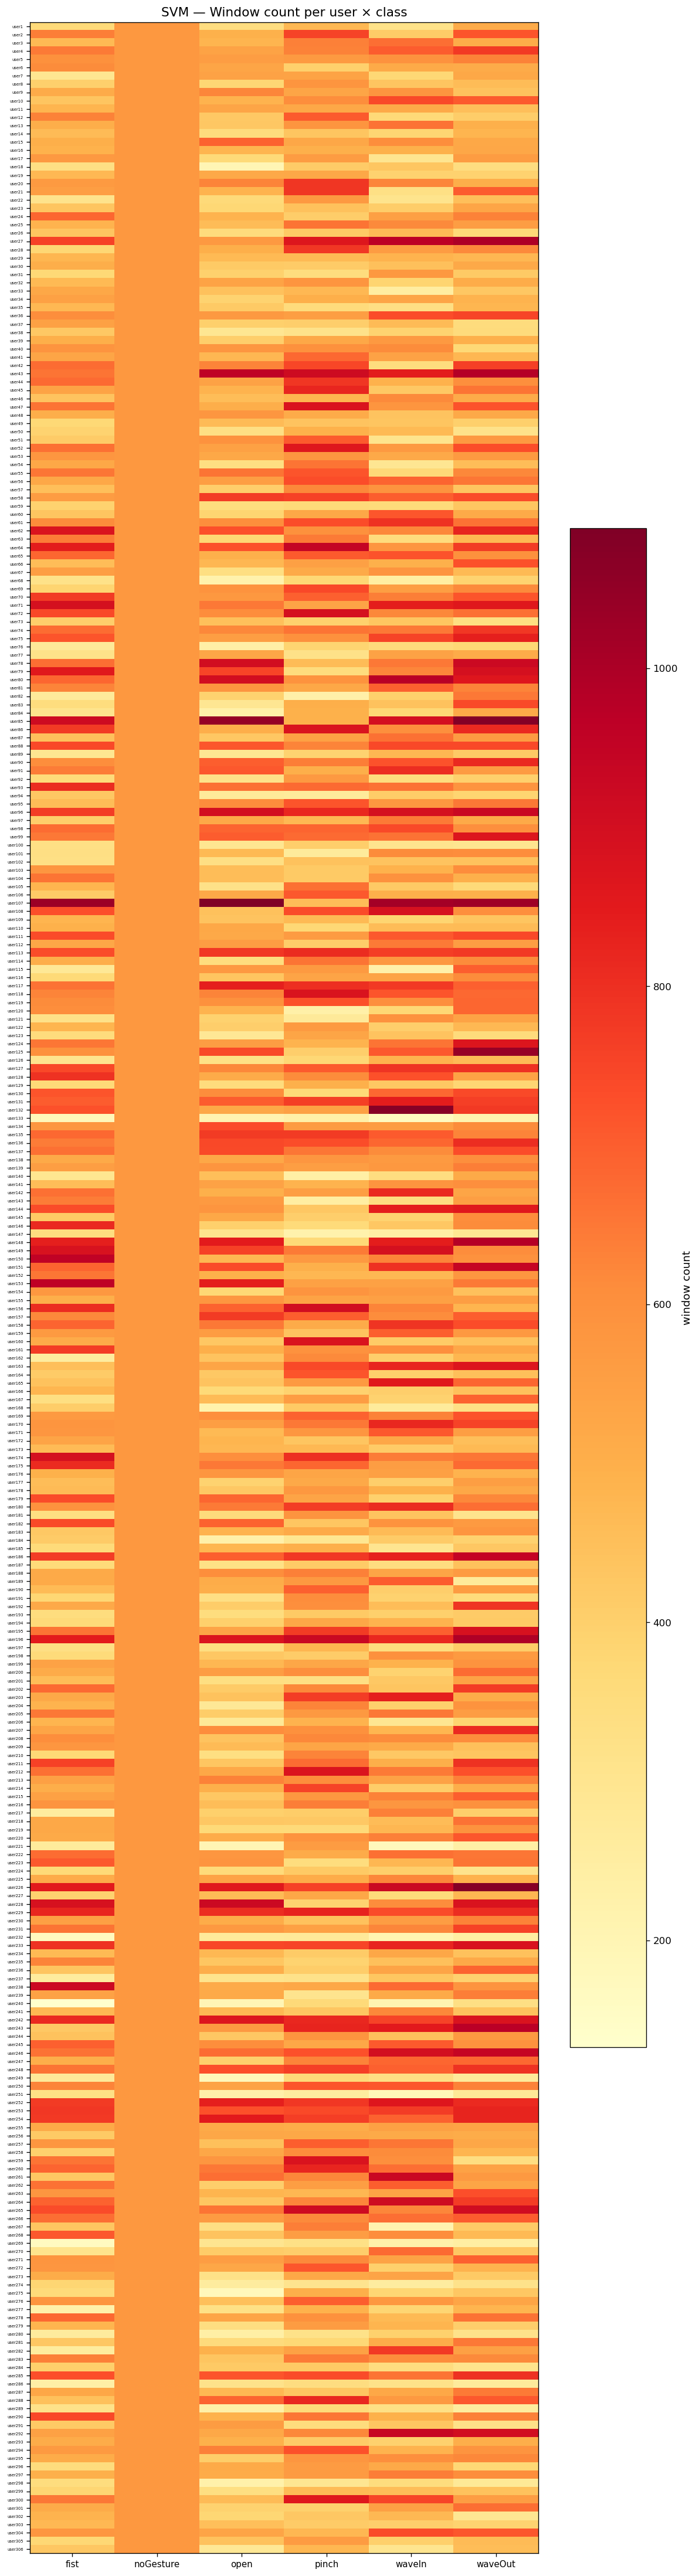

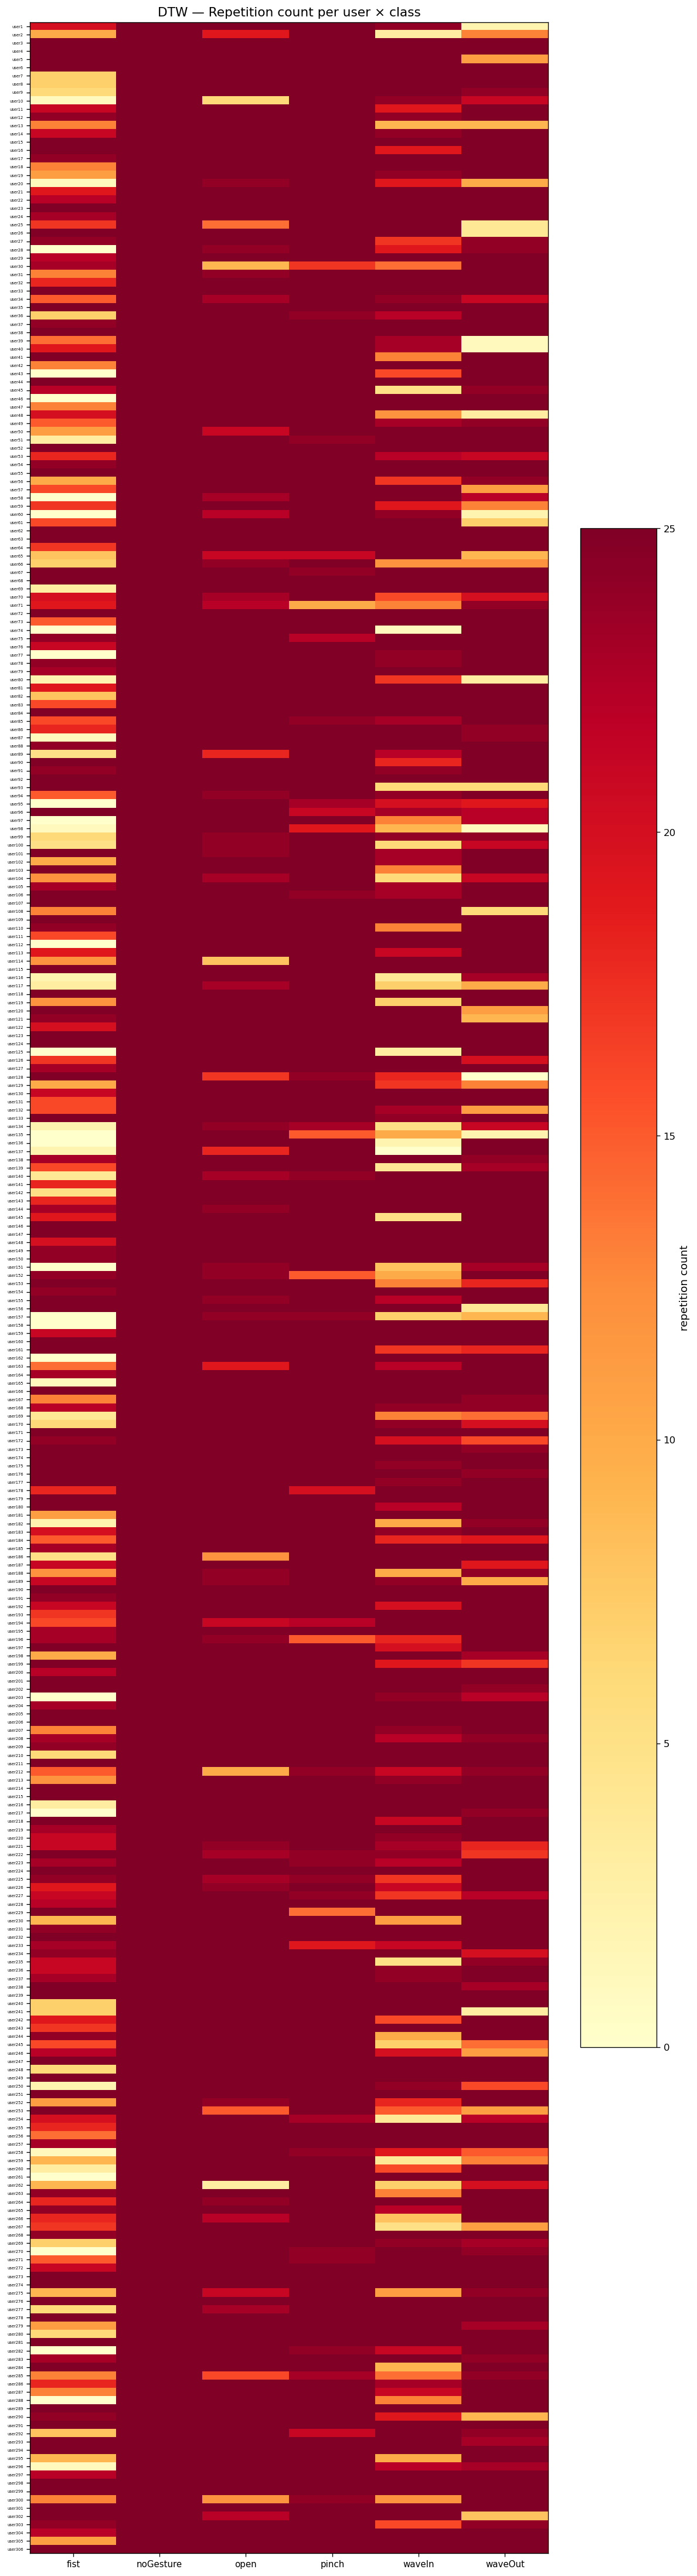

In [7]:
def plot_class_heatmap(df, name, unit="samples"):
    pivot = df.groupby(["user", "label"]).size().unstack(fill_value=0)
    pivot = pivot.reindex(columns=labels_order)
    # sort users numerically
    pivot = pivot.loc[sorted(pivot.index, key=lambda u: int(u.replace("user", "")))]

    fig, ax = plt.subplots(figsize=(10, max(6, len(pivot) * 0.12)))
    im = ax.imshow(pivot.values, aspect="auto", cmap="YlOrRd")
    ax.set_yticks(range(len(pivot)))
    ax.set_yticklabels(pivot.index, fontsize=4)
    ax.set_xticks(range(len(labels_order)))
    ax.set_xticklabels(labels_order, fontsize=9)
    ax.set_title(f"{name} — {unit.capitalize()} per user × class")
    plt.colorbar(im, ax=ax, label=unit, shrink=0.6)
    plt.tight_layout()
    plt.show()

plot_class_heatmap(df_svm, "SVM", unit="window count")
plot_class_heatmap(dtw_reps, "DTW", unit="repetition count")

## 7 — SVM vs DTW: class-count comparison

,SVM (windows),DTW (repetitions)
label,,
fist,165283,5241
noGesture,175950,7650
open,154370,7404
pinch,171537,7525
waveIn,169374,6505
waveOut,178647,6780


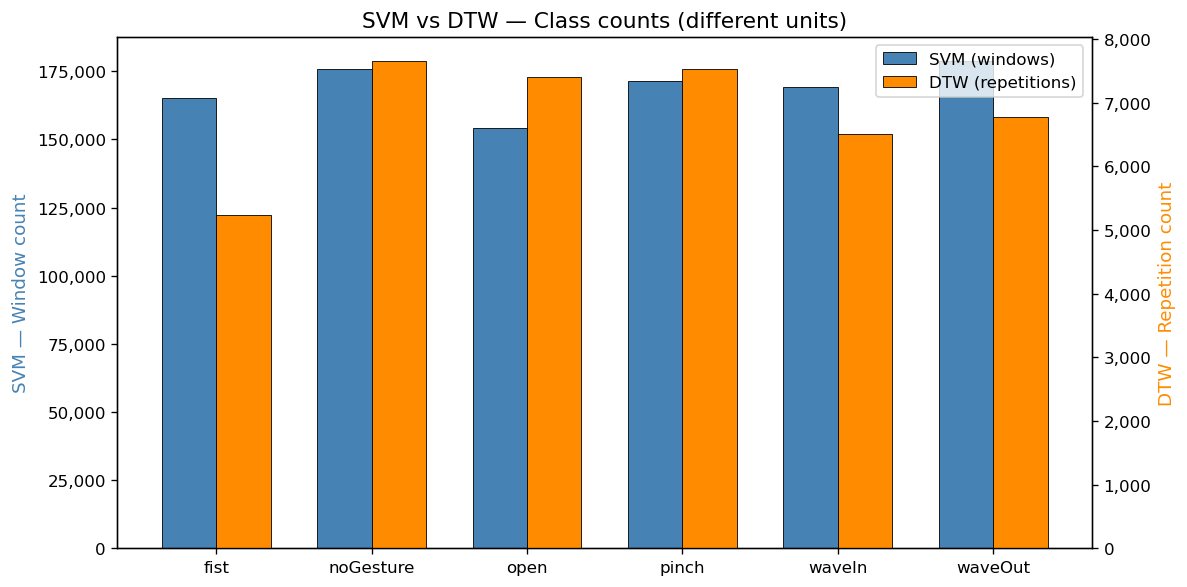

In [8]:
svm_counts = df_svm["label"].value_counts().reindex(labels_order)
dtw_counts = dtw_reps["label"].value_counts().reindex(labels_order)

comp = pd.DataFrame({
    "SVM (windows)":       svm_counts,
    "DTW (repetitions)":   dtw_counts,
})
comp.index.name = "label"
display(comp)

x = np.arange(len(labels_order))
w = 0.35

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()  # independent y-axes because units differ

b1 = ax1.bar(x - w/2, svm_counts, w, label="SVM (windows)", color="steelblue", edgecolor="black", linewidth=0.5)
b2 = ax2.bar(x + w/2, dtw_counts, w, label="DTW (repetitions)", color="darkorange", edgecolor="black", linewidth=0.5)

ax1.set_xticks(x)
ax1.set_xticklabels(labels_order)
ax1.set_ylabel("SVM — Window count", color="steelblue")
ax2.set_ylabel("DTW — Repetition count", color="darkorange")
ax1.set_title("SVM vs DTW — Class counts (different units)")
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

lines = [b1, b2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")
plt.tight_layout()
plt.show()

## 8 — Summary & Verdict

In [9]:
def balance_verdict(ir, name):
    if ir < 1.1:
        status = "BALANCED"
    elif ir < 1.5:
        status = "MILDLY IMBALANCED"
    elif ir < 3.0:
        status = "MODERATELY IMBALANCED"
    else:
        status = "HIGHLY IMBALANCED"
    return status

print("╔══════════════════════════════════════════════════╗")
print("║           DATASET BALANCE SUMMARY               ║")
print("╠══════════════════════════════════════════════════╣")
print(f"║  SVM  IR = {svm_ir:.4f}  →  {balance_verdict(svm_ir, 'SVM'):<24s}║")
print(f"║  DTW  IR = {dtw_ir:.4f}  →  {balance_verdict(dtw_ir, 'DTW'):<24s}║")
print("╠══════════════════════════════════════════════════╣")
print("║  IR thresholds used:                            ║")
print("║    < 1.10  →  Balanced                          ║")
print("║    < 1.50  →  Mildly imbalanced                 ║")
print("║    < 3.00  →  Moderately imbalanced              ║")
print("║    ≥ 3.00  →  Highly imbalanced                 ║")
print("╚══════════════════════════════════════════════════╝")

╔══════════════════════════════════════════════════╗
║           DATASET BALANCE SUMMARY               ║
╠══════════════════════════════════════════════════╣
║  SVM  IR = 1.1573  →  MILDLY IMBALANCED       ║
║  DTW  IR = 1.4596  →  MILDLY IMBALANCED       ║
╠══════════════════════════════════════════════════╣
║  IR thresholds used:                            ║
║    < 1.10  →  Balanced                          ║
║    < 1.50  →  Mildly imbalanced                 ║
║    < 3.00  →  Moderately imbalanced              ║
║    ≥ 3.00  →  Highly imbalanced                 ║
╚══════════════════════════════════════════════════╝
